# MP2: Optical Flow

In this lab, you'll calculate optical flow from a low-res video, then use the optical flow field to interpolate high-res images to make a high-res video.

In order to make sure everything works, you might want to go to the command line, and run

    pip install -r requirements.txt
    
This will install the modules that are used on the autograder, including numpy, h5py, and the gradescope utilities.

---------------------------------------------------------------------
## Part 1: Loading the video and image files

First, let's load the low-res video.  This video was posted by NairobiPapel(Kamaa) at https://commons.wikimedia.org/wiki/File:Cat_Play.webm under a CreativeCommons Attribution-ShareAlike license.

In [1]:
from IPython.display import Video

Video("cat.webm")


The high-res images are provided once per 30 frames (once per second).  There are four of them, corresponding to frames $30s$ for $s\in\{0,\ldots,3\}$.  Let's load them all as grayscale (add the three colors).

In [2]:
import matplotlib.image
import numpy as np
highres = np.zeros((91,270,480),dtype=float)
for s in range(4):
    highres[30*s,:,:] = np.sum(matplotlib.image.imread('highres/cat%4.4d.jpg'%(30*s)).astype(float), axis=2)
print(highres.dtype)
print(highres.shape)


float64
(91, 270, 480)


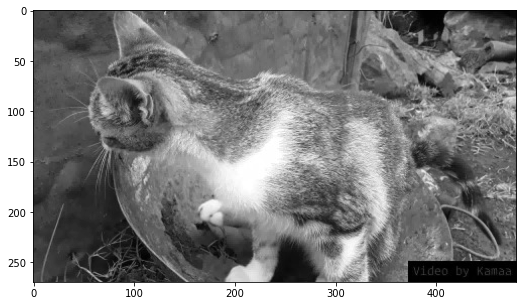

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
plt.imshow(highres[0,:,:], cmap='gray')

You would need ffmpeg in order to extract frames from the video.  You should probably install ffmpeg.  But just in case you haven't, the frames are provided in the lowres directory.

In [4]:
import numpy as np
lowres = np.zeros((91,135,240),dtype=float)
for t in range(91):
    lowres[t,:,:] = np.sum(matplotlib.image.imread('lowres/cat%4.4d.jpg'%(t)).astype(float), axis=2)
print(lowres.dtype)
print(lowres.shape)



float64
(91, 135, 240)


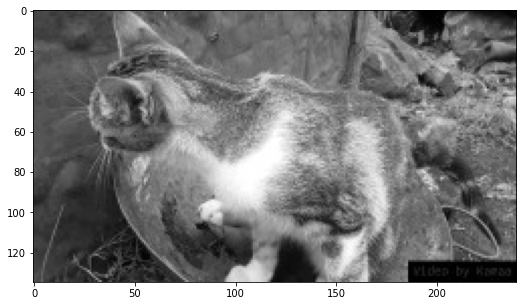

In [5]:
plt.figure(figsize=(14, 5))
plt.imshow(lowres[0,:,:], cmap='gray')

------------------------------------------------------------
## Part 2: Further Smooth the Low-Res Image

First, load submitted.py.

In [6]:
import submitted
import importlib
importlib.reload(submitted)
print(submitted.__doc__)


This is the module you'll submit to the autograder.

There are several function definitions, here, that raise RuntimeErrors.  You should replace
each "raise RuntimeError" line with a line that performs the function specified in the
function's docstring.



First, in order to make the gradient estimation smoother, we'll smooth all of the low-res images

In [7]:
help(submitted.smooth_video)

Help on function smooth_video in module submitted:

smooth_video(x, sigma, L)
    y = smooth_video(x, sigma, L)
    Smooth the video using a sampled-Gaussian smoothing kernel.
    
    x (TxRxC) - a video with T frames, R rows, C columns
    sigma (scalar) - standard deviation of the Gaussian smoothing kernel
    L (scalar) - length of the Gaussian smoothing kernel
    y (TxRxC) - the same video, smoothed in the row and column directions.



The Gaussian smoothing kernel is:
$$h[n] = 
\left\{\begin{array}{ll}
\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2}\left(\frac{n-(L-1)/2}{\sigma}\right)^2} & 0\le n\le L-1\\0 & \mbox{otherwise}\end{array}\right.$$

You should implement this as a separable filter, i.e., convolve in both the row and column directions:
$$z[r,c] = h[r]\ast_r x[r,c]$$
$$y[r,c] = h[c]\ast_c z[r,c]$$
where $\ast_r$ means convolution across rows (in the $r$ direction), and $\ast_c$ means convolution across columns.

In [100]:
importlib.reload(submitted)
smoothed = submitted.smooth_video(lowres, sigma=1.5, L=7)
print(smoothed.shape)


(91, 135, 240)


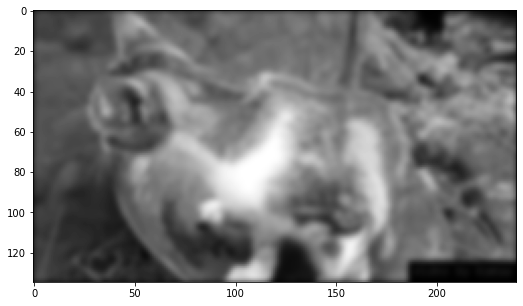

In [101]:
plt.figure(figsize=(14, 5))
plt.imshow(smoothed[0,:,:], cmap='gray')


-------------------------------------
## Part 3: Calculating  the Image Gradient

Now that we have the smoothed images, let's find their gradient.  Use a central difference filter:
$$h[n] = 0.5\delta[n-1]-0.5\delta[n+1]$$

You will need to compute three different gradients: the column gradient $g_c$, row gradient $g_r$, and frame gradient $g_t$, defined as:
$$g_t[t,r,c] = h[t] \ast_t x[t,r,c]$$
$$g_r[t,r,c] = h[r] \ast_r x[t,r,c]$$
$$g_c[t,r,c] = h[c] \ast_c x[t,r,c]$$
where $x[t,r,c]$ should be the smoothed video.

In [72]:
importlib.reload(submitted)
help(submitted.gradients)

Help on function gradients in module submitted:

gradients(x)
    gt, gr, gc = gradients(x)
    Compute gradients using a first-order central finite difference.
    
    x (TxRxC) - a video with T frames, R rows, C columns
    gt (TxRxC) - gradient in the time direction
    gr (TxRxC) - gradient in the vertical direction
    gc (TxRxC) - gradient in the horizontal direction



All of the samples of $x[t,r,c]$ are positive, of course, but the three gradient images have equal parts positive and negative values.  Matplotlib will automatically normalize those things for us, but it's useful to put a colorbar on each image, so we can see what values of the gradient are matched to each color in the image.

In [103]:
importlib.reload(submitted)
gt, gr, gc =  submitted.gradients(smoothed)
print(gt.shape)

(91, 135, 240)


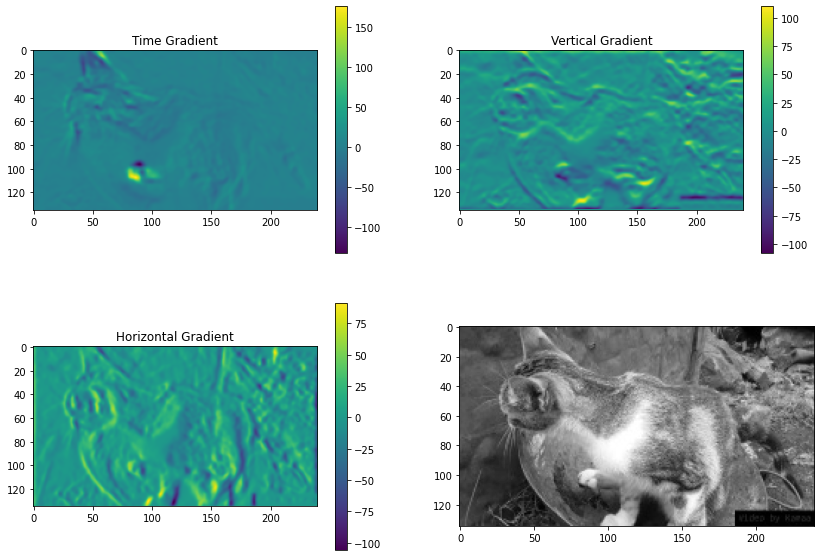

In [104]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(14, 10))
plt1 = ax1.imshow(gt[1,:,:])
plt.colorbar(plt1, ax=ax1)
ax1.set_title('Time Gradient')
plt2 = ax2.imshow(gr[1,:,:])
plt.colorbar(plt2, ax=ax2)
ax2.set_title('Vertical Gradient')
plt3 = ax3.imshow(gc[1,:,:])
plt.colorbar(plt3, ax=ax3)
ax3.set_title('Horizontal Gradient')
ax4.imshow(lowres[1,:,:],cmap='gray')


-------------------------------------------------------------
## Part 4: Estimate Optical Flow using the Lucas-Kanade Algorithm

Wikipedia has good summaries of optical flow and the Lucas-Kanade algorithm:
* https://en.wikipedia.org/wiki/Optical_flow
* https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method

We will calculate optical flow in 

In [21]:
importlib.reload(submitted)
help(submitted.lucas_kanade)

Help on function lucas_kanade in module submitted:

lucas_kanade(gt, gr, gc, H, W)
    vr, vc = lucas_kanade(gt, gr, blocksize)
    
    gt (TxRxC) - gradient in the time direction
    gr (TxRxC) - gradient in the vertical direction
    gc (TxRxC) - gradient in the horizontal direction
    H (scalar) - height (in rows) of each optical flow block
    W (scalar) - width (in columns) of each optical flow block
    
    Within each HxW block of each frame, you should create:
     - b vector, of size (H*W,1)
     - A matrix, of size (H*W,2)
     - calculate v = pinv(A)*b
     - assign vr and vc as the two elements of the v vector
    
    vr (Txint(R/H)xint(C/W)) - pixel velocity in vertical direction
    vc (Txint(R/H)xint(C/W)) - pixel velocity in horizontal direction



In [105]:
importlib.reload(submitted)
vr, vc = submitted.lucas_kanade(gt,gr,gc,6,6)
print(vr.shape)

(91, 22, 40)


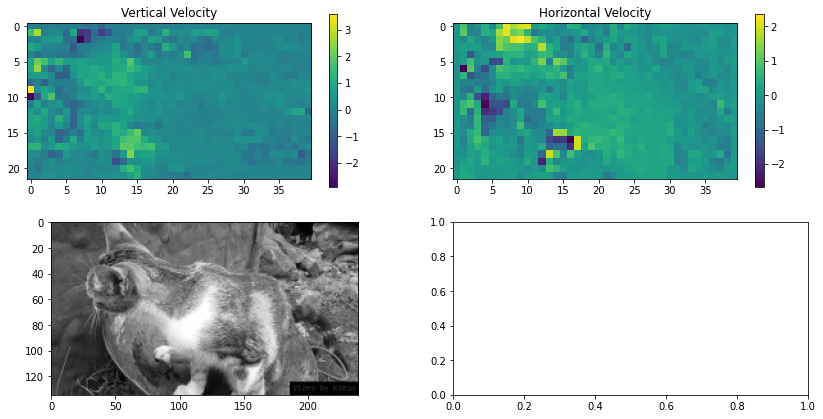

In [106]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(14, 7))
plt1 = ax1.imshow(vr[1,:,:])
plt.colorbar(plt1, ax=ax1)
ax1.set_title('Vertical Velocity')
plt2 = ax2.imshow(vc[1,:,:])
plt.colorbar(plt2, ax=ax2)
ax2.set_title('Horizontal Velocity')
ax3.imshow(lowres[1,:,:],cmap='gray')

In [22]:
from IPython.display import Video

Video("cat.webm")

-----------------------------------------------------------
## Part 5: Median Filtering

The pixel velocity fields look pretty good, except for a few single-pixel outliers.  Those can be eliminated by using median filtering.

We will use a 2D median filtering algorithm.  This follows exactly the code at 
https://en.wikipedia.org/wiki/Median_filter#Two-dimensional_median_filter_pseudo_code, except for the edges of the image.  The Wikipedia code deals with the edges of the image by simply not computing them.  In our case, we'll deal with the edges by computing the median in a window of reduced size.  Thus:


In [50]:
importlib.reload(submitted)
help(submitted.medianfilt)

Help on function medianfilt in module submitted:

medianfilt(x, H, W)
    y = medianfilt(x, H, W)
    Median-filter the video, x, in HxW blocks.
    
    x (TxRxC) - a video with T frames, R rows, C columns
    H (scalar) - the height of median-filtering blocks
    C (scalar) - the width of median-filtering blocks
    y (TxRxC) - y[t,r,c] is the median of the pixels x[t,rmin:rmax,cmin:cmax], where
      rmin = max(0,r-int((H-1)/2))
      rmax = min(R,r+int((H-1)/2)+1)
      cmin = max(0,c-int((W-1)/2))
      cmax = min(C,c+int((W-1)/2)+1)



In [110]:
importlib.reload(submitted)
smooth_vr = submitted.medianfilt(vr,3,3)
smooth_vc = submitted.medianfilt(vc,3,3)
print(smooth_vr.shape)

(91, 22, 40)


Text(0.5, 1.0, 'Horizontal Velocity, Median')

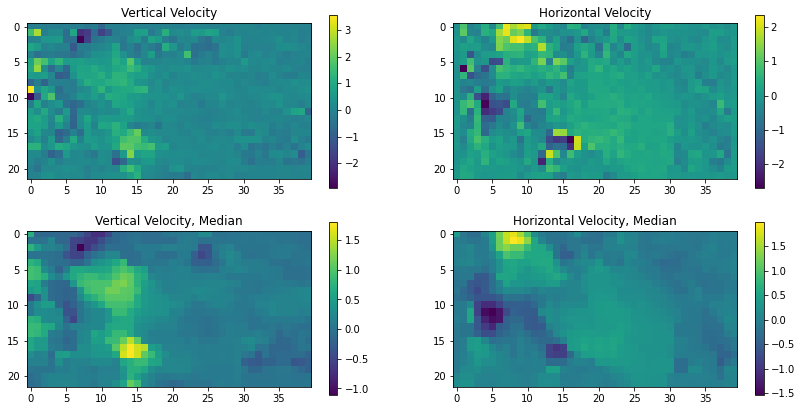

In [111]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(14, 7))
plt1 = ax1.imshow(vr[1,:,:])
plt.colorbar(plt1, ax=ax1)
ax1.set_title('Vertical Velocity')
plt2 = ax2.imshow(vc[1,:,:])
plt.colorbar(plt2, ax=ax2)
ax2.set_title('Horizontal Velocity')
plt3 = ax3.imshow(smooth_vr[1,:,:])
plt.colorbar(plt3, ax=ax3)
ax3.set_title('Vertical Velocity, Median')
plt4 = ax4.imshow(smooth_vc[1,:,:])
plt.colorbar(plt4, ax=ax4)
ax4.set_title('Horizontal Velocity, Median')


-----------------------------------------------------------------------------
## Part 6: Upsampling the Velocity Fields

Now, in order to use the velocity fields to synthesize a high-res video, we need to upsample the velocity fields to the same size as the high-res images, i.e., $270\times 480$.

The low-res image is $135\times 240$, which is $2$ times smaller than the high-res image.  The Lucas-Kanade algorithm further downsampled by $6\times 6$, so our total upsampling factor is $12\times 12$.

We will use bilinear interpolation (linear in both row and column dimensions) in order to upsample the image.  This has two parts: (1) upsample to the desired image size, and then (2) filter in both row and column directions by a linear interpolation kernel.

In [53]:
importlib.reload(submitted)
help(submitted.interpolate)

Help on function interpolate in module submitted:

interpolate(x, U)
    y = interpolate(x, U)
    Upsample and interpolate an image using bilinear interpolation.
    
    x (TxRxC) - a video with T frames, R rows, C columns
    U (scalar) - upsampling factor
    y (Tx(U*R)x(U*C)) - interpolated image



In [142]:
importlib.reload(submitted)
highres_vc = submitted.interpolate(smooth_vc, 12)
highres_vr = submitted.interpolate(smooth_vr, 12)
print(highres_vc.shape)

(91, 264, 480)


(91, 264, 480)
(91, 264, 480)


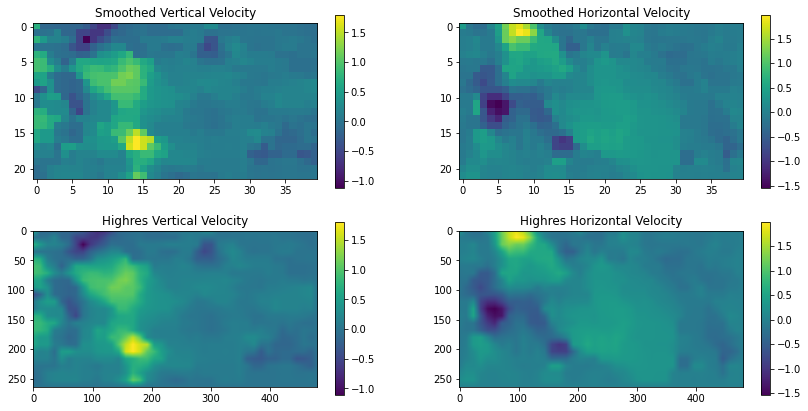

In [143]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(14, 7))
plt1 = ax1.imshow(smooth_vr[1,:,:])
plt.colorbar(plt1, ax=ax1)
ax1.set_title('Smoothed Vertical Velocity')
plt2 = ax2.imshow(smooth_vc[1,:,:])
plt.colorbar(plt2, ax=ax2)
ax2.set_title('Smoothed Horizontal Velocity')
plt3 = ax3.imshow(highres_vr[1,:,:])
plt.colorbar(plt3, ax=ax3)
ax3.set_title('Highres Vertical Velocity')
plt4 = ax4.imshow(highres_vc[1,:,:])
plt.colorbar(plt4, ax=ax4)
ax4.set_title('Highres Horizontal Velocity')
print(highres_vc.shape)
print(highres_vr.shape)

-------------------------------------------------------------------------------------
## Part 7: Quantizing the Velocity Vectors

The upsampled velocity vectors have two remaining problems:
1. They express velocities in the low-resolution image, not the high-resolution.  For example, a movement of -1.5 pixels in the low-res image corresponds to a movement of -3 pixels in the high-res image.
2. They are real-valued.  In order to move a pixel, we want the velocity vectors to be quantized to integers.  

The function `scale_velocities` scales and then quantizes the velocity vectors.  Use `int(np.round(...))` to do the quantization.

In [56]:
importlib.reload(submitted)
help(submitted.scale_velocities)

Help on function scale_velocities in module submitted:

scale_velocities(v, U)
    delta = scale_velocities(v, U)
    Scale the velocities in v by a factor of U,
    then quantize them to the nearest integer.
    
    v (TxRxC) - T frames, each is an RxC velocity image
    U (scalar) - an upsampling factor
    delta (TxRxC) - integers closest to v*U



In [40]:
importlib.reload(submitted)
scaled_vr = submitted.scale_velocities(highres_vr,2)
scaled_vc = submitted.scale_velocities(highres_vc,2)

In [41]:
print(scaled_vc.shape)

(91, 264, 480)


Text(0.5, 1.0, 'Scaled Horizontal Velocity')

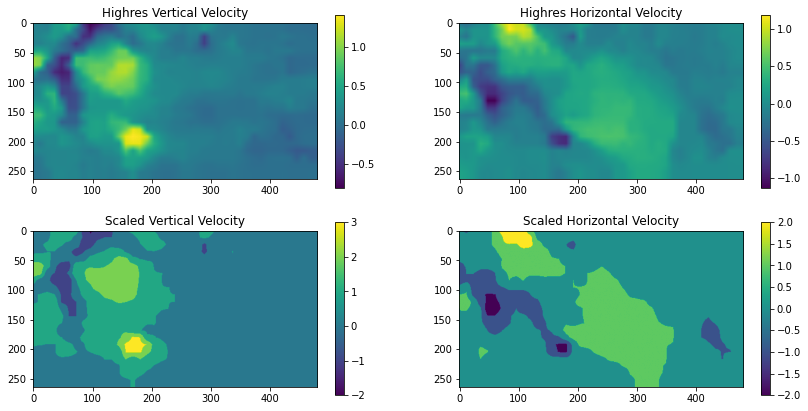

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(14, 7))
plt1 = ax1.imshow(highres_vr[1,:,:])
plt.colorbar(plt1, ax=ax1)
ax1.set_title('Highres Vertical Velocity')
plt2 = ax2.imshow(highres_vc[1,:,:])
plt.colorbar(plt2, ax=ax2)
ax2.set_title('Highres Horizontal Velocity')
plt3 = ax3.imshow(scaled_vr[1,:,:])
plt.colorbar(plt3, ax=ax3)
ax3.set_title('Scaled Vertical Velocity')
plt4 = ax4.imshow(scaled_vc[1,:,:])
plt.colorbar(plt4, ax=ax4)
ax4.set_title('Scaled Horizontal Velocity')


----------------------------------------------------------------------------------
## Part 8: Creating the High-Resolution Video Using Velocity Fill

So, now, we already have the high-resolution video `highres[t,:,:]` for the frames $t\in\left\{0,30,60,90\right\}$.  For all other frames, the high-resolution video is currently zero.

Let's use the velocity vector to fill in the missing frames:

$$\mbox{highres}[t,r,c]=
\left\{\begin{array}{ll}
\mbox{highres}[t,r,c] & t\in\left\{0,30,60,90\right\}\\
\mbox{highres}[t-1,r,c] & r\ge 264\\
\mbox{highres}[t-1,r-v_r[t-1,r,c],c-v_c[t-1,r,c]] & \mbox{otherwise}
\end{array}\right.$$

where $v_r[t,r,c]$ and $v_c[t,r,c]$ refer to the ones that have been interpolated, scaled, and quantized.

`scaled_vr` and `scaled_vc` have shape of (264,480), but `highres` has a shape of (270,480), so the last six rows of every image are just copied from the preceding image.



In [56]:
importlib.reload(submitted)
print(scaled_vr.shape)
help(submitted.velocity_fill)


(91, 264, 480)
Help on function velocity_fill in module submitted:

velocity_fill(x, vr, vc, keep)
    y = velocity_fill(x, vr, vc, keep)
    Fill in missing frames by copying samples with a shift given by the velocity vector.
    
    x (T,R,C) - a video signal in which most frames are zero
    vr (T,Ra,Cb) - the vertical velocity field, integer-valued
    vc (T,Ra,Cb) - the horizontal velocity field, integer-valued
        Notice that Ra and Cb might be less than R and C.  If they are, the remaining samples 
        of y should just be copied from y[t-1,r,c].
    keep (array) -  a list of frames that should be kept.  Every frame not in this list is
     replaced by samples copied from the preceding frame.
    
    y (T,R,C) - a copy of x, with the missing frames filled in.



In [67]:
importlib.reload(submitted)
highres_filled = submitted.velocity_fill(highres, scaled_vr, scaled_vc, [0,30,60,90])
print(highres_filled.shape)

91 270 480
(91, 270, 480)


In [54]:
print(highres.shape)

(91, 270, 480)


Text(0.5, 1.0, 'Frame 2')

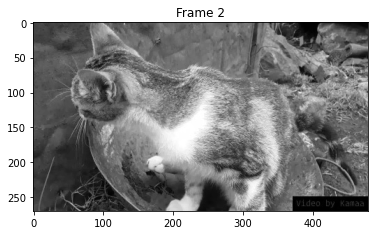

In [69]:
idx = 2
plt.imshow(highres_filled[idx,:,:],cmap='gray')
plt.title(f'Frame {idx}')

Text(0.5, 1.0, 'Frame 30 (Unchanged)')

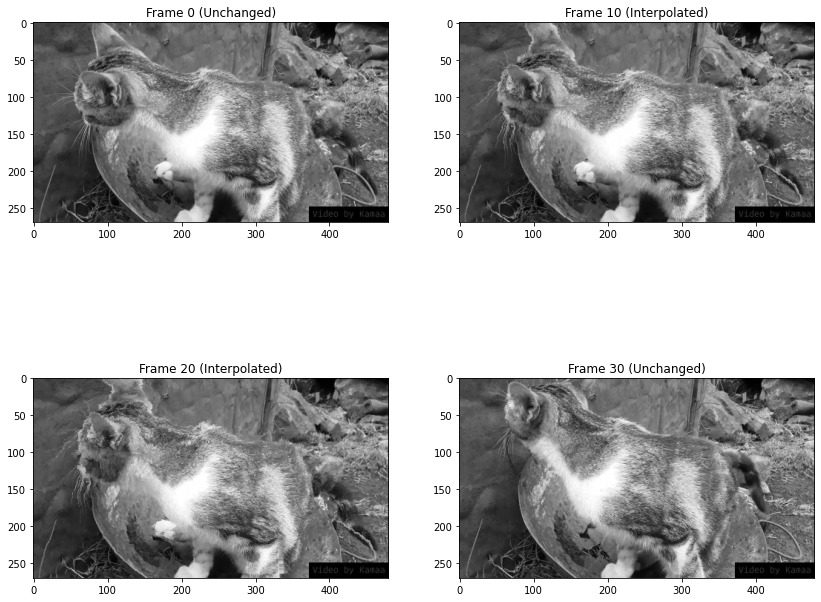

In [70]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(14, 12))
ax1.imshow(highres_filled[0,:,:],cmap='gray')
ax1.set_title('Frame 0 (Unchanged)')
ax2.imshow(highres_filled[10,:,:], cmap='gray')
ax2.set_title('Frame 10 (Interpolated)')
ax3.imshow(highres_filled[20,:,:], cmap='gray')
ax3.set_title('Frame 20 (Interpolated)')
ax4.imshow(highres_filled[30,:,:], cmap='gray')
ax4.set_title('Frame 30 (Unchanged)')


In this example, you can see that optical flow is working, but not really very well.  It stretches out the cat's head to the left, but doesn't start turning it, so the turn in frame 30 is sudden.  Apparently our optical flow algorithm is missing the turn.

In a real application, we would try to connect the velocity vectors both forward and backward in time, in order to make a smooth trajectory for every pixel.

If you'd like to watch the resulting video, you will need to first install ffmpeg.  Then you can use the following block of code to save the images to the directory `generated`, then use the following command to make the video:

`ffmpeg -r 30 -i generated/cat%04d.jpg generated.webm`

In [71]:
import os, matplotlib.image
os.makedirs('generated',exist_ok=True)
for t in range(91):
    filename = 'cat%4.4d.jpg'%(t)
    matplotlib.image.imsave(os.path.join('generated',filename),highres_filled[t,:,:],cmap='gray')

-----------------------------------------------------
## Part 9: How to Debug!!

If you reached this point in the notebook, then probably your code is working well, but before you run the autograder on  the  server, you should first run it on your own machine.

You can do that by going to a  terminal, and running the  following command line:

    python grade.py
    
If you get any error messages, we recommend that you use the provided `solutions.hdf5` in order to debug.  That can be done as follows:

In [81]:
import h5py
with h5py.File('solutions.hdf5','r') as f:
    print(list(f.keys()))

['gc', 'gr', 'gt', 'highres', 'highres_filled', 'highres_vc', 'highres_vr', 'keep', 'lowres', 'scaled_vc', 'scaled_vr', 'smooth_vc', 'smooth_vr', 'smoothed', 'vc', 'vr']


In [102]:
print('debug')
print(smoothed[0, :5, :5])
with h5py.File('solutions.hdf5','r') as f:
    print(f['smoothed'][0, :5, :5])

debug
[[ 78.39898    107.08489734 123.65788589 131.12022264 133.69556797]
 [105.05908192 143.15684299 165.0185944  174.78708544 177.97787265]
 [119.14934921 161.62750157 185.56770813 195.99263457 199.07100246]
 [124.80552576 168.32480353 192.13347318 201.92497836 204.1845582 ]
 [126.58113867 169.86517169 192.7760256  201.39204248 202.36159365]]
[[ 78.40664547 107.04953108 123.52903793 130.84293542 133.32869581]
 [105.08236756 143.12824417 164.86925763 174.44649644 177.5359869 ]
 [119.19470345 161.62646308 185.44571999 195.68323038 198.686951  ]
 [124.81722708 168.29032959 192.00078991 201.65742993 203.89784605]
 [126.48997947 169.71293432 192.55517771 201.10606043 202.10437241]]


debug
(91, 264, 480)
[-8.42820131e-03 -7.61818809e-03 -6.80817486e-03 -5.99816164e-03
 -5.18814841e-03 -4.37813519e-03 -3.56812196e-03 -2.75810874e-03
 -1.94809551e-03 -1.53892056e-03 -1.12974561e-03 -7.20570655e-04
 -3.11395704e-04  9.77792482e-05  5.06954200e-04  9.16129152e-04
  1.32530410e-03  1.73447906e-03  2.14365401e-03  2.55282896e-03
  2.96200391e-03  3.14956819e-03  3.33713247e-03  3.52469675e-03
  3.71226104e-03  3.89982532e-03  4.08738960e-03  4.27495388e-03
  4.46251816e-03  4.65008244e-03]
[-0.0090809  -0.00824878 -0.00741665 -0.00658452 -0.0057524  -0.00492027
 -0.00408815 -0.00325602 -0.0024239  -0.00196504 -0.00150618 -0.00104732
 -0.00058847 -0.00012961  0.00032925  0.00078811  0.00124697  0.00170582
  0.00216468  0.00262354  0.0030824   0.00326984  0.00345728  0.00364473
  0.00383217  0.00401961  0.00420706  0.0043945   0.00458194  0.00476939]
(91, 264, 480)


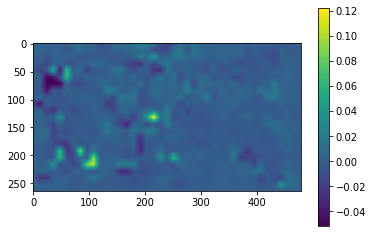

In [145]:
print('debug')
print(highres_vc.shape)
print(highres_vc[1, 100:130, 478])
with h5py.File('solutions.hdf5','r') as f:
    print(f['highres_vc'][1, 100:130, 478])
    print(f['highres_vc'].shape)
    plt.imshow(highres_vc[1] - f['highres_vc'][1])
    plt.colorbar()

In [98]:
importlib.reload(submitted)
with h5py.File('solutions.hdf5','r')  as f:
    highres_filled_ref = np.array(f['highres_filled'][:])
    highres_ref = np.array(f['highres'][:])
    scaled_vr_ref = np.array(f['scaled_vr'][:])
    scaled_vc_ref = np.array(f['scaled_vc'][:])
    keep_ref = np.array(f['keep'][:])
    highres_filled_hyp = submitted.velocity_fill(highres_ref, scaled_vr_ref, scaled_vc_ref, keep_ref)


Text(0.5, 0.92, 'Difference between the two')

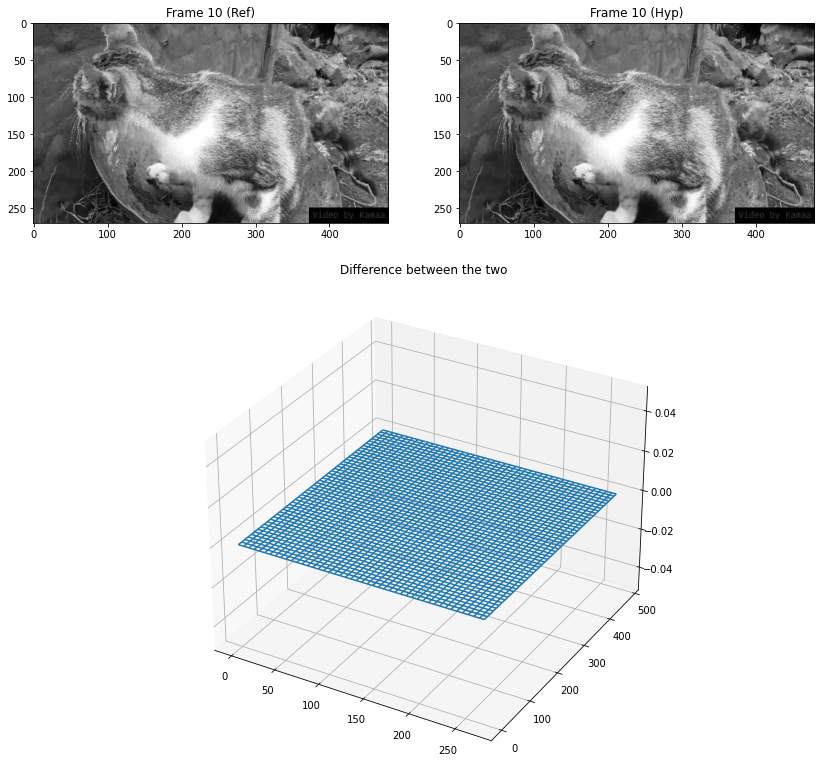

In [117]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(3,2,1)
ax.imshow(highres_filled_ref[10,:,:],cmap='gray')
ax.set_title('Frame 10 (Ref)')
ax = fig.add_subplot(3,2,2)
ax.imshow(highres_filled_hyp[10,:,:], cmap='gray')
ax.set_title('Frame 10 (Hyp)')
ax = fig.add_subplot(3,2,(3,6), projection='3d')
T,R,C = highres_filled_hyp.shape
rows = np.repeat(np.arange(R).reshape((R,1)), C, axis=1)
cols = np.repeat(np.arange(C).reshape((1,C)), R, axis=0)
ax.plot_wireframe(rows,cols,highres_filled_hyp[10,:,:]-highres_filled_ref[10,:,:])
ax.set_title('Difference between the two')


---------------------
## Extra Credit

You can earn up to 10%  extra credit on this MP by finishing the file called `extra.py`, and submitting it to the autograder.

When you unpack the file ``mp2_extra.zip``, it will give you the following files:

* ``extra.py``.  
*  ``tests/test_extra.py``.  

The extra credit assignment is actually pretty simple this time: given a low-resoluton video, and a small set of high-resolution frames, try to reconstruct the high-resolution video.

The function that the grader will call is this function called `animate`:

In [66]:
import extra
importlib.reload(extra)
help(extra.animate)

Help on function animate in module extra:

animate(highres_frames, lowres_video)
    highres_video = animate(highres_frames, lowres_video)
    Use a low-res video, and a few highres frames, to animate a highres video.
    
    highres_frames (shape=(Th,Rh,Ch)) - highres frames (Rh>Rl, Ch>Cl) at low temporal rate (Th<Tl)
    lowres_video (shape=(Tl,Rl,Cl)) - lowres frames at high temporal rate
    highres_video (shape=(Tl,Rh,Ch)) - highres video at high temporal rate
    
    In order to compute highres_frames, you may use any method you wish.
    It doesn't need to be related to optical flow.



As noted in the docstring, your answer doesn't need to have anything to do with optical flow; it can be any answer you like.  There are some remarkably simple answers that give remarkably good results, so please feel free to be creative (exception: don't just download the ground truth from the web.  That won't work well, anyway, because you'll fail the hidden tests).

Solutions for the cat video are provided in `extra_solutions.hdf5`.  This file contains three objects:

* f['highres_frames'] - the input frames
* f['lowres_video'] - the input lowres video
* f['highres_ref'] - the  reference video, i.e., the true original high-res video.



In [67]:
with h5py.File('extra_solutions.hdf5','r') as f:
    print(list(f.keys()))

['highres_frames', 'highres_ref', 'lowres_video']


We do not know of any solution to  this problem that will **exactly** reconstruct `f['highres_ref']`.  Instead, you will receive more or less extra credit points depending on the SNR with which you're able to estimate `f['highres_ref']`.  SNR is defined in `tests/text_extra.py`, which has the same definition as the following line:

In [68]:
importlib.reload(extra)
with h5py.File('extra_solutions.hdf5','r')  as f:
    highres_video = extra.animate(f['highres_frames'][:], f['lowres_video'][:])
    SNR = 10*np.log10(np.sum(np.square(f['highres_ref'][:]))/np.sum(np.square(highres_video-f['highres_ref'][:])))
    print('The SNR of this solution is %g dB'%(SNR))

The SNR of this solution is 18.1645 dB


If you want to see where your reconstructed image differs from the original image, you can do it in the following way. 

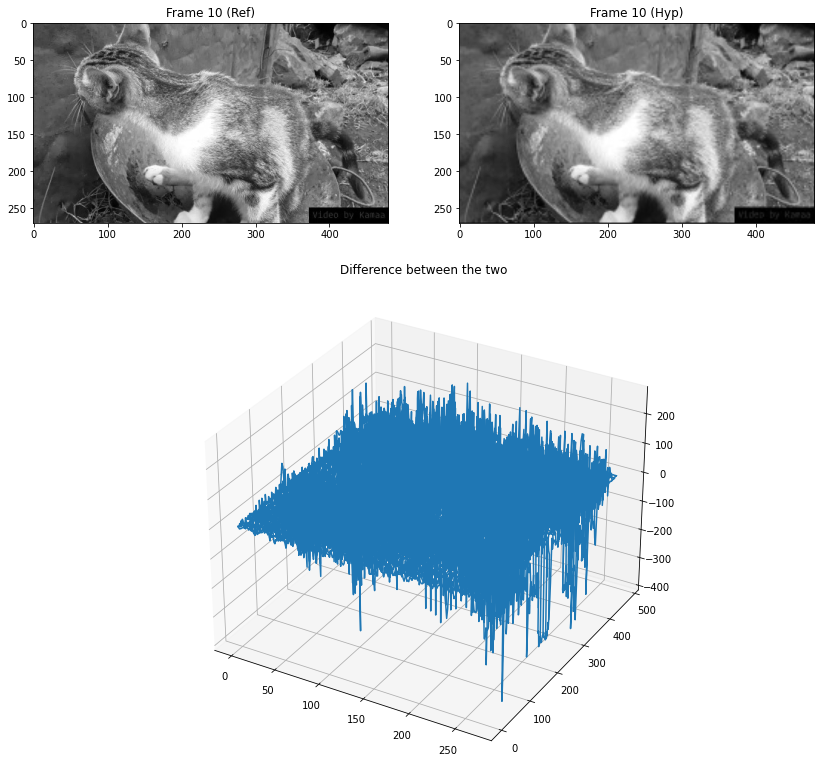

In [69]:
with h5py.File('extra_solutions.hdf5','r')  as f:
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(3,2,1)
    ax.imshow(f['highres_ref'][10,:,:],cmap='gray')
    ax.set_title('Frame 10 (Ref)')
    ax = fig.add_subplot(3,2,2)
    ax.imshow(highres_video[10,:,:], cmap='gray')
    ax.set_title('Frame 10 (Hyp)')
    ax = fig.add_subplot(3,2,(3,6), projection='3d')
    T,R,C = highres_video.shape
    rows = np.repeat(np.arange(R).reshape((R,1)), C, axis=1)
    cols = np.repeat(np.arange(C).reshape((1,C)), R, axis=0)
    ax.plot_wireframe(rows,cols,highres_video[10,:,:]-f['highres_ref'][10,:,:])
    ax.set_title('Difference between the two')
